Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [16]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
#interactive plotting in separate window
#%matplotlib qt 
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [24, 16]#[12, 8]

import numpy as np
import sympy
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
from utils import save_data, load_data
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Folder dir for saving and loading files

In [3]:
# model_name = 'test_psm_long2'
# model_name ='test'
# model_name = 'mtm_3links'
# model_name = 'mtm'
# model_name = 'mtm_spring'
# model_name = 'mtm_2spring'
# model_name = 'mtm_2spring_tendon'
# model_name = 'mtm_4links_parallel'
# model_name = 'mtm_3links_parallel'

model_name = 'ur10'

model_folder = 'data/' + model_name + '/model/'

---
# 2 - Robot modelling

## Robot geometry definition in following order

| Joint number | prev link | succ links | $a$ | $\alpha$ | $d$ | $\theta$ | link inertia | motor inertia | friction |
|--------------|-----------|------------|-----|----------|-----|----------|--------------|---------------|---------|

In [4]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 = new_sym('q:11')
_pi = sympy.pi

dh = []
springs = []
friction_type = []
tendon_couplings = []


if model_name =='test':
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, False),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, False)]
    q = q1
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.0613
    q_o = 23.0/180*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    springs = [tau_s]
    friction_type = ['Coulomb', 'viscous', 'offset']
elif model_name == 'mtm':
    # define paralelogram coordinate relation
    q3 = -q2 + q8
    q9 = -q8 + q2
    q10 = q8 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [5],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   4,  [6],    0,     _pi/2,  0,        q5,       True,  False, True),
          (6,   5,  [7],    0,     -_pi/2, 0,        q6+_pi/2, True,  False, True),
          (7,   6,  [],     0,     -_pi/2, 0,        q7+_pi,   True,  False, True),
          (8,   1,  [9],    0,     -_pi/2, 0,        q8+_pi,   True,  False, True),
          (9,   8,  [10],   0.1,   0,      0,        q9-_pi/2, True,  False, True),
          (10,  9,  [],     0.279, 0,      0,        q10,      False, False, True)]

    q = q5
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.0613
    q_o = 23.0/180.0*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    #springs = [tau_s]
    
    friction_type = ['Coulomb', 'viscous', 'offset']
    print("MTM")
elif model_name == 'mtm_spring':
    # define paralelogram coordinate relation
    q3 = -q2 + q8
    q9 = -q8 + q2
    q10 = q8 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [5],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   4,  [6],    0,     _pi/2,  0,        q5,       True,  False, True),
          (6,   5,  [7],    0,     -_pi/2, 0,        q6+_pi/2, True,  False, True),
          (7,   6,  [],     0,     -_pi/2, 0,        q7+_pi,   True,  False, True),
          (8,   1,  [9],    0,     -_pi/2, 0,        q8+_pi,   True,  False, True),
          (9,   8,  [10],   0.1,   0,      0,        q9-_pi/2, True,  False, True),
          (10,  9,  [],     0.279, 0,      0,        q10,      False, False, True)]

    q = q5
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.0613
    q_o = 23.0/180.0*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    springs = [tau_s]
    
    friction_type = ['Coulomb', 'viscous', 'offset']
    print(model_name)
elif model_name == 'mtm_2spring':
    # define paralelogram coordinate relation
    q3 = -q2 + q8
    q9 = -q8 + q2
    q10 = q8 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [5],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   4,  [6],    0,     _pi/2,  0,        q5,       True,  False, True),
          (6,   5,  [7],    0,     -_pi/2, 0,        q6+_pi/2, True,  False, True),
          (7,   6,  [],     0,     -_pi/2, 0,        q7+_pi,   True,  False, True),
          (8,   1,  [9],    0,     -_pi/2, 0,        q8+_pi,   True,  False, True),
          (9,   8,  [10],   0.1,   0,      0,        q9-_pi/2, True,  False, True),
          (10,  9,  [],     0.279, 0,      0,        q10,      False, False, True)]

    q = q5
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.0613
    q_o = 23.0/180.0*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    springs = [tau_s, -q4]
    
    friction_type = ['Coulomb', 'viscous', 'offset']
    print(model_name)
elif model_name == 'mtm_2spring_tendon':
    # define paralelogram coordinate relation
    q3 = -q2 + q8
    q9 = -q8 + q2
    q10 = q8 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [5],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   4,  [6],    0,     _pi/2,  0,        q5,       True,  False, True),
          (6,   5,  [7],    0,     -_pi/2, 0,        q6+_pi/2, True,  False, True),
          (7,   6,  [],     0,     -_pi/2, 0,        q7+_pi,   True,  False, True),
          (8,   1,  [9],    0,     -_pi/2, 0,        q8+_pi,   True,  False, True),
          (9,   8,  [10],   0.1,   0,      0,        q9-_pi/2, True,  False, True),
          (10,  9,  [],     0.279, 0,      0,        q10,      False, False, True)]

    q = q5
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.0613
    q_o = 23.0/180.0*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    springs = [tau_s, -q4]
    
    friction_type = ['Coulomb', 'viscous', 'offset']
    tendon_couplings = [(4, 3, 2.0/3.0)] # tau_3 += 2/3*tau_4
    print(model_name)
elif model_name == 'mtm_3links_parallel':
    # define paralelogram coordinate relation
    q3 = -q2 + q4
    q5 = -q4 + q2
    q6 = q4 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,4],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.2794, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   1,  [5],    0,     -_pi/2, 0,        q4+_pi,   True,  False, True),
          (5,   4,  [6],   0.1,   0,      0,        q5-_pi/2, True,  False, True),
          (6,   5,  [],     0.2794, 0,      0,        q6,      False, False, True)]
    friction_type = ['Coulomb', 'viscous', 'offset']
    #springs = [q1, q2, q3]
elif model_name == 'mtm_4links_parallel':
    # define paralelogram coordinate relation
    q3 = -q2 + q5
    q6 = -q5 + q2
    q7 = q5 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,5],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [0],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   1,  [6],     0,     -_pi/2, 0,        q5+_pi,   True,  False, True),
          (6,   5,  [7],   0.1,   0,      0,        q6-_pi/2, True,  False, True),
          (7,   6,  [],     0.279, 0,      0,        q7,      False, False, True)]
    friction_type = ['Coulomb', 'viscous']
elif model_name == 'mtm_3links':
    dh = [(0,   -1, [1],    0,      0,      0,          0,         False, False, False),
          (1,   0,  [2],    0,      0,      -0.21537,   q1,        True,  False, True),
          (2,   1,  [3],    0,      -_pi/2, 0,          q2+_pi/2,  True,  False, True),
          (3,   2,  [4],    0.279,  0,      0,          q3+_pi/2,  True,  True,  True)]
    # springs = [q1]
    friction_type = ['Coulomb', 'viscous']
elif (model_name == 'test_psm'):
    beta = 0.2908
    beta2 = 0.0767 + beta
    delta = 0.6025
    x = [None]*10
    x[0] = (0,   -1, [1],        0,              0,     0,                       0,      False,  False, False) # Base
    x[1] = (1,   0,  [2],        0,     sympy.pi/2,     0,           q1+sympy.pi/2,       True,  False,  True) # Yaw
    x[2] = (2,   1,  [3, 4],        0, -sympy.pi/2,     0,              sympy.pi/2,       False, False, False) # -- Intermediate
    x[3] = (3,   2,  [5, 6],  -0.0296,           0,     0,    q2-beta - sympy.pi/2,        True,  False, True) # Pitch Back
    x[4] = (4,   2,  [] ,     0.0664 ,           0,     0,    q2-beta - sympy.pi/2,        True,  False, True) # Pitch Front                                    )
    x[5] = (5,   2,  [7],     -0.0296,           0,     0,   q2-beta2 - sympy.pi/2,        False,  False, False)    # Intermediate
    x[6] = (6,   3,  [8],       0.150,           0,     0,    -q2+beta+sympy.pi/2,      True,  False,  True)    # Pitch Bottom
    x[7] = (7,   5,  [],       0.1842,           0,     0,    -q2+beta2+sympy.pi/2,     True,  False,  True)    # Pitch Top
    x[8] = (8,   6,  [9],       0.516,           0,     0,                      q2,     True,  False,  True)    # Pitch End
    x[9] = (9,   8,  [10],      0.043, -sympy.pi/2,-.28809+q3,          sympy.pi/2,     True,  False, True)    # Main Insertion
    dh = x
    friction_type = ['Coulomb', 'viscous', 'offset']              
elif (model_name == 'test_psm_long2'):
    beta = 0.2908
    beta2 = 0.0767 + beta
    delta = 0.6025
    
    x = [None]*17
    x[0]  = ( 0,  -1,  [1],          0,           0,     0,                       0, False, False, False) # Base
    x[1]  = ( 1,   0,  [2],          0,  sympy.pi/2,     0,           q1+sympy.pi/2,  True, False,  True) # Yaw
    x[2]  = ( 2,   1,  [3, 4, 5],       0, -sympy.pi/2,     0,              sympy.pi/2, False, False, False) # -- Intermediate
    x[3]  = ( 3,   2,  [6, 10], -0.0296,       0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Back
    x[4]  = ( 4,   2,  [] ,     0.0664,           0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Front                                    )
    x[5]  = ( 5,   2,  [7],    -0.0296,           0,     0,   q2-beta2 - sympy.pi/2, False, False, False)    # Intermediate
    x[6]  = ( 6,   3,  [8],      0.150,           0,     0,     -q2+beta+sympy.pi/2,  True, False,  True)    # Pitch Bottom
    x[7]  = ( 7,   5,   [],     0.1842,           0,     0,    -q2+beta2+sympy.pi/2,  True, False,  True)    # Pitch Top
    x[8]  = ( 8,   6,  [9],      0.516,           0,     0,                      q2,  True, False,  True)    # Pitch End
    x[9]  = ( 9,   8, [12],      0.043, -sympy.pi/2,-.28809+q3,          sympy.pi/2,  True, False,  True)    # Main Insertion
    x[10] = (10,   3, [11],          0,           0,     0,         beta+sympy.pi/2, False, False, False) # Intermediate Counterweight
    x[11] = (11,  10,   [],       -0.1, +sympy.pi/2, delta*q3,                    0,  True, False,  True) # Counterweight
    
    x[12] = (12,   9, [13],          0,           0,0.4162,          -sympy.pi/2+q4, False,  True,  True) # Tool Roll 
    x[13] = (13,  12, [14],          0, -sympy.pi/2,     0,          -sympy.pi/2+q5, False,  True,  True) # Tool Pitch
    x[14] = (14,  13, [15,16],  0.0091, -sympy.pi/2,     0,          -sympy.pi/2+q6, False,  True,  True) # Tool Yaw
    x[15] = (15,  14, [],            0,           0,     0,                     -q7, False, False,  True) # Gripper1
    x[16] = (16,  15, [],            0,           0,     0,                      q7, False,  True,  True) # Gripper2
    dh = x
    friction_type = ['Coulomb', 'viscous', 'offset']
elif model_name == 'ur10':
    dh = [(0,   -1, [1],    0,      0,      0,           0,         False, False, False),
          (1,   0,  [2],    0,      0,      0.128,       q1,        True,  False, False),
          (2,   1,  [3],    0,      -_pi/2, 0.176,    q2-_pi/2,     True,  False, False),
          (3,   2,  [4],    0.612,  0,      -0.128,      q3,        True,  False, False),
          (4,   3,  [5],    0.572,  0,      0.116,      q4+_pi/2,   True,  False, False),
          (5,   4,  [6],    0,    _pi/2,    0.116,       q5,        True,  False, False),
          (6,   5,  [],     0,    -_pi/2,   0.092,       q6,        True,  False, False)]

    
    friction_type = []
    print("UR10")
else:
    raise Exception("No robot name matches " + name)
print(friction_type)
robot_def = RobotDef(dh,
                     springs=springs,
                     tendon_couplings=tendon_couplings,
                     dh_convention='mdh',
                     friction_type=friction_type)

UR10
[]


In [4]:
robot_def.dq_for_frame

In [5]:
robot_def.coordinates_joint_type

['R', 'R', 'R', 'R', 'R', 'R']

In [6]:
robot_def.bary_params

## Create kinematics chain

In [7]:
%time geom = Geometry(robot_def)

Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
CPU times: user 7min 30s, sys: 80.1 ms, total: 7min 30s
Wall time: 7min 30s


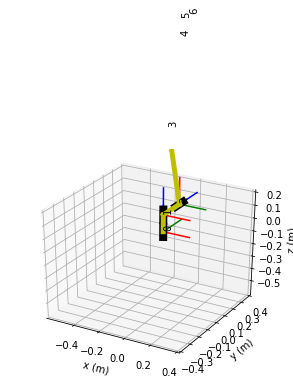

In [8]:
angle = [0, 0, 0, 0, 0, 0, 0]
geom.draw_geom(angle)

## Create dynamics

In [9]:
%time dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating the link kinetic energy of 1/6
Calculating the link kinetic energy of 2/6
Calculating the link kinetic energy of 3/6
Calculating the link kinetic energy of 4/6
Calculating the link kinetic energy of 5/6
Calculating the link kinetic energy of 6/6
Calculating joint torques...
tau of q1
tau of q2
tau of q3
tau of q4
tau of q5
tau of q6
Adding frictions and springs...
Add tendon coupling torque and motor inertia...
Calculating gregressor...
('input_vars', (q1, q2, q3, q4, q5, q6, dq1, dq2, dq3, dq4, dq5, dq6, ddq1, ddq2, ddq3, ddq4, ddq5, ddq6))
Calculating M, C and G...
Calculating base parameter...
[54 51 52 57 56 41 36 58 48 46 44 55 42 50 34 27 26 32 53 31 24 21 17 16 22
 45 43 11 14 20 12 33 13 25 15  5 40 47 59 37 39 35 49 30 38 29 23 10 28 18
 19  1  2  9  0  8  4  3  7  6]
base parameter number: 36
Creating H_b function...
Finished creating robot dynamics
CPU times: user 15min 55s, sys: 11.3 s, total: 16min 7s
Wall time: 16min 6s


In [10]:
robot_def.bary_params

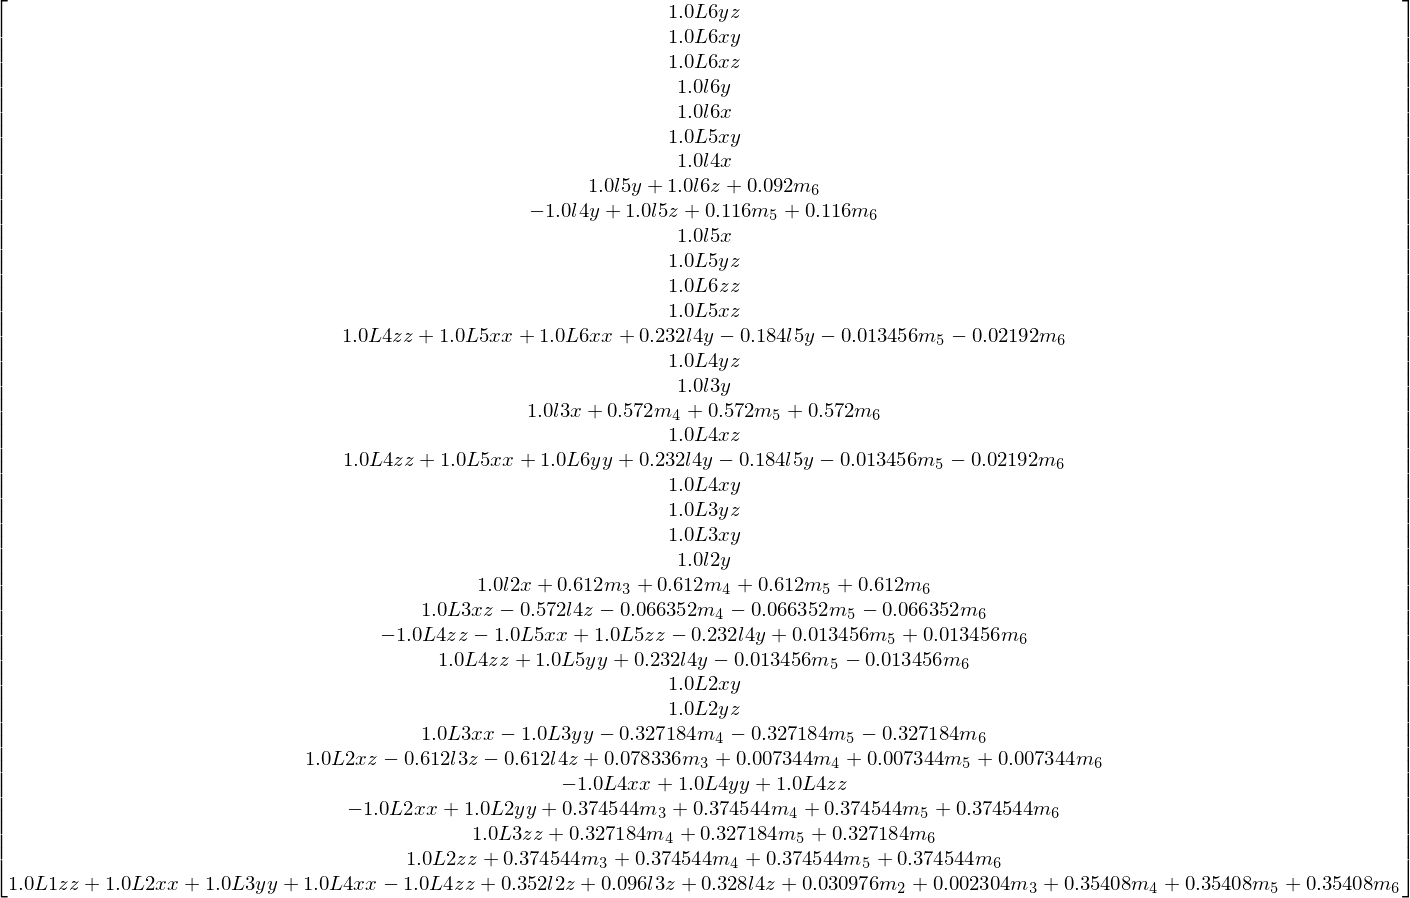

In [11]:
sympy.Matrix(dyn.base_param)

In [12]:
from data import RobotModel

# Data to be saved
robot_model = RobotModel(dyn)

# Save
save_data(model_folder, model_name, robot_model)
print('Saved {} parameters'.format(len(robot_model.base_param)))

Saved 36 parameters


In [13]:
for tendon_coupling in dyn.rbt_def.tendon_couplings:
    src_frame, dst_frame, k = tendon_coupling
    dq_src = dyn.rbt_def.dq_for_frame[src_frame]
    dq_dst = dyn.rbt_def.dq_for_frame[dst_frame]
    src_index = dyn.rbt_def.d_coordinates.index(dq_src)

    for a in range(len(dyn.rbt_def.d_coordinates)):
        dq_da = sympy.diff(dq_dst, dyn.rbt_def.d_coordinates[a])
        #tau_c[a] += dq_da * k * tau_csf[src_index]
        print(a, dq_da, k)
dyn.rbt_def.tendon_couplings 
2/3

---
# 3 - Excitation trajectory optimization

In [5]:
# model_name = 'test_psm_long2'
# model_name ='test'
# model_name = 'mtm_3links'
# model_name = 'mtm'
#model_name = 'mtm_spring'
# model_name = 'mtm_2spring'
#model_name = 'mtm_2spring_tendon'
# model_name = 'mtm_3links_parallel'
# model_name = 'mtm_4links_parallel'

model_name = 'ur10'

Load Data

In [6]:
from utils import load_data
model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder, model_name)

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [7]:
# trajectory_name = 'one'
#trajectory_name = 'two'
# trajectory_name = 'two_normalized'

trajectory_name = 'ur10'

In [17]:
from numpy import deg2rad

optimal_trajectory_folder = 'data/optimal_trajectory/'
trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'

base_freq = 0.1
fourier_order = 6

joint_constraints = []
cartesian_constraints = []

if model_name == 'mtm' or model_name == 'mtm_spring'\
    or model_name == 'mtm_2spring' or model_name == 'mtm_2spring_tendon':
    joint_constraints = [(q1, deg2rad(-57), deg2rad(29), deg2rad(-160), deg2rad(160)),
                         (q2, deg2rad(-10), deg2rad(60), deg2rad(-180), deg2rad(180)),
                         (q3, deg2rad(-30), deg2rad(30), deg2rad(-180), deg2rad(180)),
                         (q4, deg2rad(-40), deg2rad(195), -6*np.pi, 6*np.pi),
                         (q5, deg2rad(-87), deg2rad(180), -6*np.pi, 6*np.pi),
                         (q6, deg2rad(-40), deg2rad(38), -6*np.pi, 6*np.pi),
                         (q7, deg2rad(-460), deg2rad(450), -10*np.pi, 10*np.pi),
                         (q8, deg2rad(-9), deg2rad(39), deg2rad(-150), deg2rad(150))]

#     cartesian_constraints = [(3,'max',1,0.4,1),
#                              (3,'min',-1,-1,-1)]
elif model_name == 'mtm_3links':
    joint_constraints = [(q1, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                         (q2, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                         (q3, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi)]
    
    cartesian_constraints = [(1,'max',1,0.4,1),
                             (1,'min',-1,-1,-1),
                             (2,'max',1,0.4,1),
                             (2,'min',-1,-1,-1)]
    
    # MTM STUFF
#jnt_cnst = [(q1, -0.698132, 1.13446, -2, 2),(q2, -0.261799, 0.872665, -2, 2), (q3,-0.172665, 0.610865, -2, 2)]
#jnt_cnst = [(q1, -1.5, 1.5, -2, 2),(q2, -1.5, 1.5, -2, 2), (q3,-1.5, 1.5, -2, 2)]    

#crt_cnst = [(4, 'max', -0.283, 0.279, -0.25137), (4, 'min', -0.5, -0.321, -0.39137)]
#crt_cnst = [(3, 'max', -0.300, 0.3, -0.26137), (3, 'min', -0.5, -0.45, -0.53137)]
elif model_name == 'mtm_3links_parallel' or model_name == 'mtm_3links_parallel_offset':
    joint_constraints = [(q1, deg2rad(-57), deg2rad(29), deg2rad(-160), deg2rad(160)),
                         (q2, deg2rad(-10), deg2rad(60), deg2rad(-180), deg2rad(180)),
                         (q3, deg2rad(-30), deg2rad(30), deg2rad(-180), deg2rad(180)),
                         (q4, deg2rad(-9), deg2rad(39), deg2rad(-360), deg2rad(360))]
elif model_name == 'mtm_4links_parallel':
    joint_constraints = [(q1, deg2rad(-60), deg2rad(32), deg2rad(-180), deg2rad(180)),
                         (q2, deg2rad(-12), deg2rad(62), deg2rad(-180), deg2rad(180)),
                         (q3, deg2rad(-32), deg2rad(32), deg2rad(-180), deg2rad(180)),
                         (q4, deg2rad(-90), deg2rad(195), -2*np.pi, 2*np.pi),
                         (q5, deg2rad(-9), deg2rad(39), deg2rad(-360), deg2rad(360))]
elif model_name == 'psm':
    pass
elif model_name == 'test_psm_long2':
    joint_constraints = [(q1, -1.4, 1.4, -2, 2),
                         (q2, -0.5, 0.8, -2, 2),
                         (q3,0.05,0.23,-0.4,0.4),
                         (q4,-1.5,1.5,-0.4,0.4),
                         (q5,-1.5,1.5,-0.4,0.4), 
                         (q6,-1.5,1.5,-0.4,0.4),
                         (q7,0.05, 0.75,-0.4,0.4)]
elif model_name == 'ur10':
    joint_constraints = [(q1, deg2rad(-180), deg2rad(180), deg2rad(-120), deg2rad(120)),
                         (q2, deg2rad(-180), deg2rad(180), deg2rad(-120), deg2rad(120)),
                         (q3, deg2rad(-180), deg2rad(180), deg2rad(-120), deg2rad(120)),
                         (q4, deg2rad(-180), deg2rad(180), deg2rad(-120), deg2rad(120)),
                         (q5, deg2rad(-180), deg2rad(180), deg2rad(-120), deg2rad(120)),
                         (q6, deg2rad(-180), deg2rad(180), deg2rad(-120), deg2rad(120))]
else:
    raise Exception("No robot name matches " + model_name)
    
traj_optimizer = TrajOptimizer(robot_model, fourier_order, base_freq,
                               joint_constraints=joint_constraints,
                               cartesian_constraints = cartesian_constraints)
                                                                                                 
                                                                                                                     
traj_optimizer.optimize()


joint constraint number: 6
cartesian constraint number: 0
constraint number: 24
frames_constrained: []


TypeError: only integer scalar arrays can be converted to a scalar index

In [17]:
reg_norm_mat = traj_optimizer.calc_normalize_mat()

## Plot optimal excitation trajectory

In [9]:
traj_optimizer.calc_frame_traj()

AttributeError: TrajOptimizer instance has no attribute 'x_result'

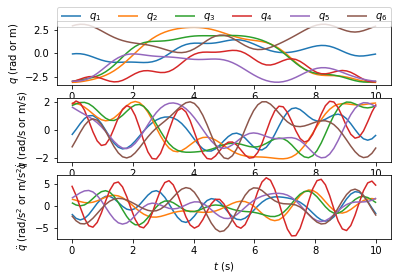

<Figure size 432x288 with 0 Axes>

In [19]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj,traj_optimizer.frame_traj,
                           traj_optimizer.const_frame_ind, robot_model.coordinates)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

traj_plotter.plot_frame_traj(True)

## Save trajectory for later use

In [24]:
dof_order_bf_x_norm = (traj_optimizer.fourier_traj.dof, fourier_order,
                       base_freq, traj_optimizer.x_result, reg_norm_mat)
save_data(trajectory_folder, trajectory_name, dof_order_bf_x_norm)

freq = 50
tf = 35 # including 5 seconds' prestable time
traj_optimizer.make_traj_csv(trajectory_folder, trajectory_name, freq, tf)

In [23]:
from IPython.display import HTML, display
import tabulate

table = []
table.append(["joint", 'qo'] +
             ["a"+str(i+1) for i in range(fourier_order)] +
             ["b"+str(i+1) for i in range(fourier_order)])
for i in range(traj_optimizer.fourier_traj.dof):
    line = []
    line.append(robot_model.coordinates[i])
    line += np.round(traj_optimizer.x_result[i*(1 + fourier_order*2): (i+1)*(1 + fourier_order*2)], 4).tolist()
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

joint,qo,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
q1,0.2039,-0.3197,-0.4009,0.2419,0.5564,-0.0487,0.4007,0.4413,-0.5248,0.2557,0.1569,-0.4919,-0.184
q2,-0.2017,0.6045,-0.3484,-0.406,-0.2797,0.3726,0.0984,1.7864,0.2651,-0.512,0.1613,0.2546,-0.0101
q3,-0.2791,0.5373,0.2492,-0.6748,-0.3121,0.3353,0.3408,1.5757,0.3169,0.0175,0.1033,-0.1914,-0.0651
q4,-1.5322,-0.2307,-0.1746,0.251,-0.255,0.0002,0.9342,0.8554,-0.3087,0.3193,-0.3503,0.2985,1.0355
q5,-1.5738,0.6662,-0.4599,-0.1677,0.0858,-0.2625,-0.0635,0.3172,0.4345,1.2586,-0.0001,-0.0905,-0.2528
q6,1.6498,-0.3282,-0.1655,0.5665,0.4689,0.5264,0.0044,-0.6134,-0.4648,0.7917,-0.8658,0.1956,-0.2846


---
# Data processing

In [6]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

## Load data

### Load robot model

In [8]:
# Names as Arguments
# model_name = 'test_psm_long'
# model_name = 'mtm_3links'
# model_name = 'mtm'
# model_name = 'mtm_spring'
# model_name = 'mtm_2spring_tendon'
#model_name == 'mtm_3links_parallel'
# model_name == 'mtm_4links_parallel'
model_name = 'ur10'
training_trajectory_name = 'ur10'


model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder,model_name)


trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
dof, fourier_order, base_freq, traj_optimizer_result, reg_norm_mat = load_data(trajectory_folder,
                                                                               training_trajectory_name)
print("dof: {}".format(dof))
print("Fourier order: {}".format(fourier_order))
print("Base frequency: {}".format(base_freq))

dof: 6
Fourier order: 6
Base frequency: 0.1


In [9]:
robot_model.coordinates

### Load traning data set

In [10]:
# training_trajectory_name = 'one'

results_folder = 'data/' + model_name +'/measured_trajectory/'
training_results_data_file = results_folder + training_trajectory_name + '_results.csv'

trajectory_sampling_rate = 500
t_train, q_raw_train, dq_raw_train, tau_raw_train = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)

# Reverse the process to get the original effort for each motor for the MTM
if 'mtm' in model_name:
    tau_raw_train[:,1] = tau_raw_train[:,1] - tau_raw_train[:,2] + 0.5515/0.8235 * tau_raw_train[:, 3]
    tau_raw_train[:,2] = tau_raw_train[:,2] - 0.5515/0.8235 * tau_raw_train[:, 3]

(<type 'numpy.ndarray'>, (1490, 18))


### Load test data set

In [51]:
test_trajectory_name = 'two'

results_folder = 'data/' + model_name +'/measured_trajectory/'
test_results_data_file = results_folder + test_trajectory_name + '_results.csv'

trajectory_sampling_rate = 500
t_test, q_raw_test, dq_raw_test, tau_raw_test = load_trajectory_data(test_results_data_file,
                                                                trajectory_sampling_rate)

# Reverse the process to get the original effort for each motor for the MTM
if 'mtm' in model_name:
    tau_raw_test[:,1] = tau_raw_test[:,1] - tau_raw_test[:,2] + 0.5515/0.8235 * tau_raw_test[:, 3]
    tau_raw_test[:,2] = tau_raw_test[:,2] - 0.5515/0.8235 * tau_raw_test[:, 3]

IOError: File data/ur10/measured_trajectory/two_results.csv does not exist

## Calculate filter cut-off frequency

In [11]:
# times of the highest frequency in the Fourier series
fc_mult = 4.0

fc = base_freq * fourier_order * fc_mult
print("Cut frequency: {}".format(fc))

Cut frequency: 2.4


## Differentiation and filtering

### Traning data

q_raw shape: (1490, 6)
plot shape: 460


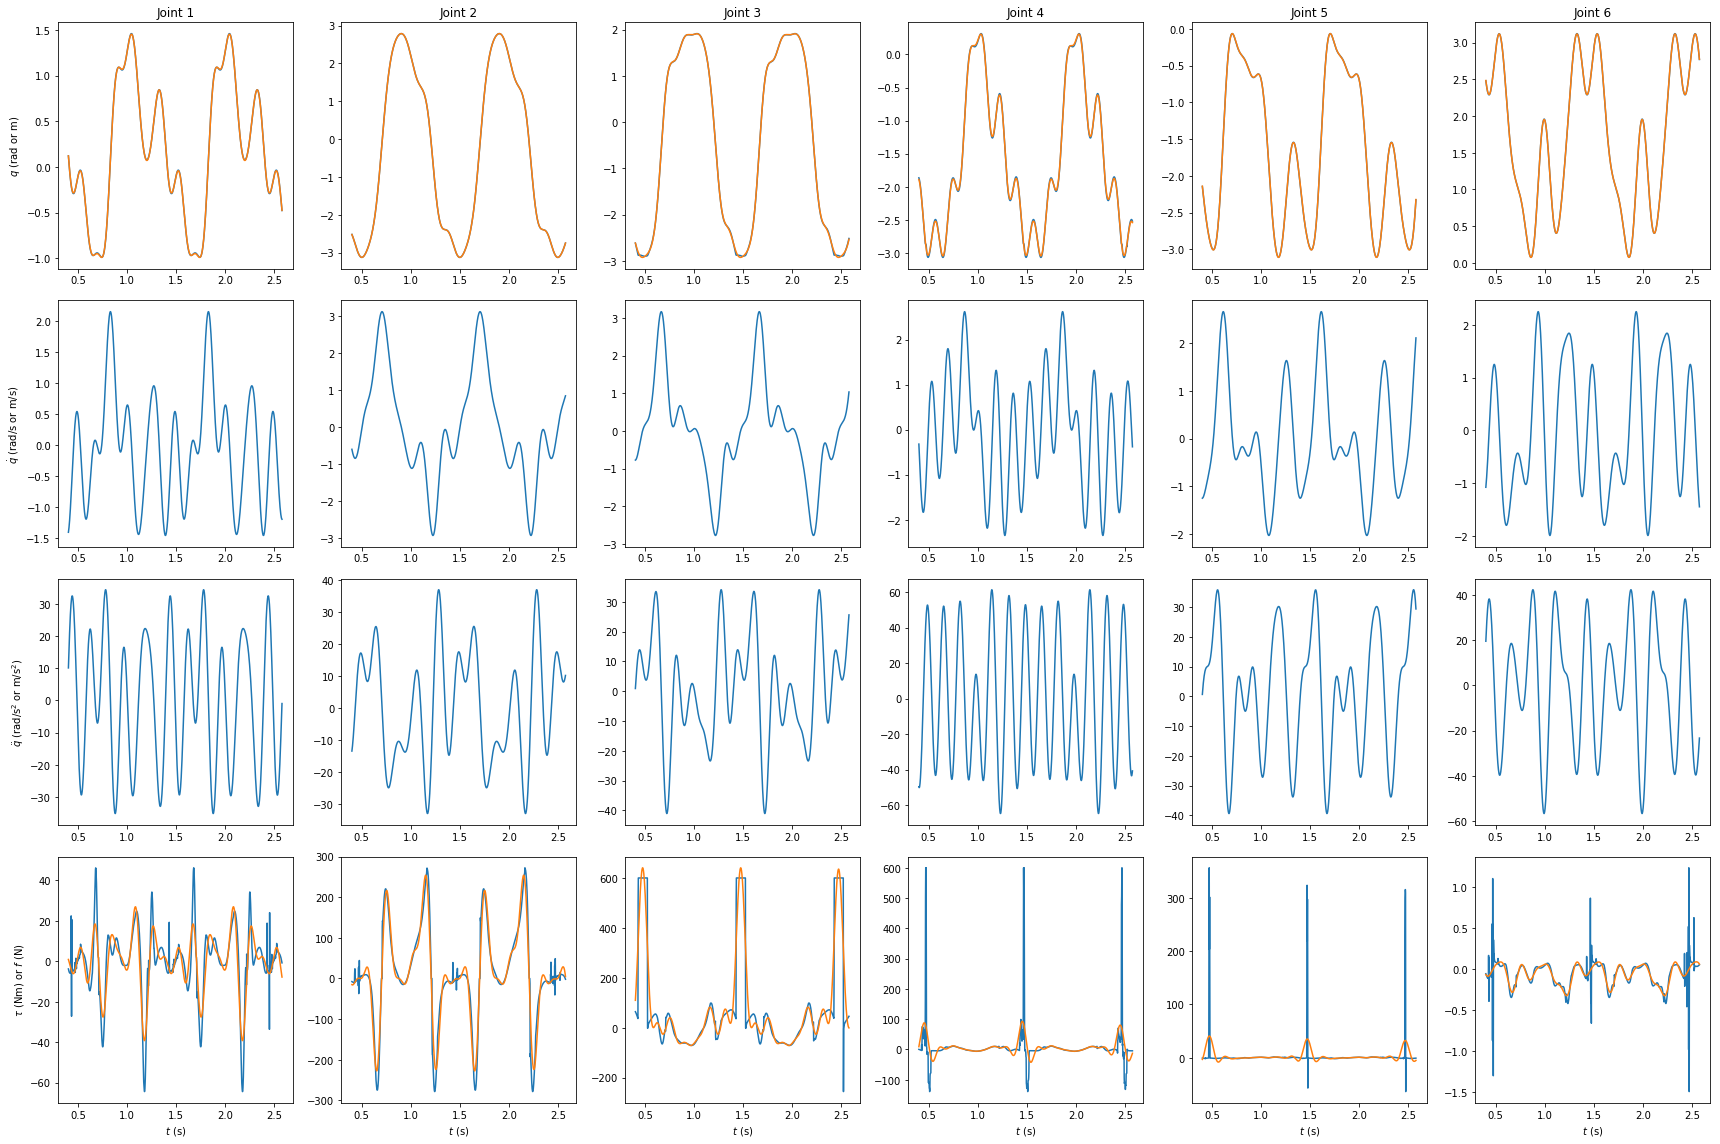

In [12]:
t_cut_train, q_f_train, dq_f_train, ddq_f_train, tau_f_train, q_raw_cut_train, tau_raw_cut_train =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_train, q_raw_train, dq_raw_train, tau_raw_train, fc, fc, fc, fc)
plot_trajectory_data(t_cut_train, q_raw_cut_train, q_f_train, dq_f_train, ddq_f_train,
                     tau_raw_cut_train, tau_f_train)

### Test data

q_raw shape: (14989, 7)
plot shape: 470


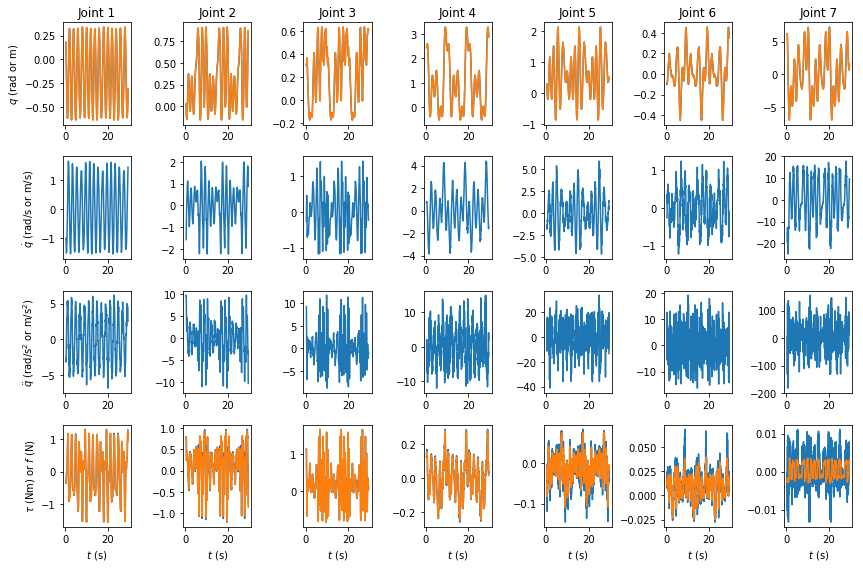

In [14]:
t_cut_test, q_f_test, dq_f_test, ddq_f_test,tau_f_test, q_raw_cut_test, tau_raw_cut_test =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_test, q_raw_test, dq_raw_test, tau_raw_test, fc, fc, fc, fc)
plot_trajectory_data(t_cut_test, q_raw_cut_test, q_f_test, dq_f_test, ddq_f_test,
                     tau_raw_cut_test, tau_f_test)

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [17]:
base_param_num = robot_model.base_num
H_b_func = robot_model.H_b_func
W_b_train, tau_s_train = gen_regressor(base_param_num, H_b_func, q_f_train,
                                       dq_f_train, ddq_f_train, tau_f_train)

In [18]:
W_b_train.shape, tau_s_train.shape
#print np.linalg.cond(W_b_train)

In [19]:
xb_ols = np.linalg.lstsq(W_b_train, tau_s_train)[0]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [20]:
#sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_ols))

from IPython.display import HTML, display
import tabulate

table = [["Base Parameter", "Value"]]

for i in range(robot_model.base_num):
    param_str = str(sympy.Matrix(robot_model.base_param)[i])
    max_disp_len = 50
    line = [param_str if len(param_str) <= max_disp_len 
            else param_str[:max_disp_len] + '...', xb_ols[i]]
    #['%.7s ...'%b if len(str(b)) > 7 else str(b)
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

Base Parameter,Value
1.0*L6yz,0.18979764625282813
1.0*L6xy,-0.7405128052024152
1.0*L6xz,-0.21385594607261624
1.0*l6y,-0.538351169805759
1.0*l6x,-0.9766678184198575
1.0*L5xy,0.6667745636683383
1.0*l4x,1.3208316281254517
1.0*l5y + 1.0*l6z + 0.092*m6,-1.1557546729464245
-1.0*l4y + 1.0*l5z + 0.116*m5 + 0.116*m6,-2.380090133935555
1.0*l5x,-1.6316808462316104


## Compare measured torque and predicted torque on the training set

### Generate predicted torque

In [34]:
tau_p_train = np.zeros(tau_f_train.shape)
tau_ps_train = W_b_train.dot(xb_ols)
for i in range(dof):
    tau_p_train[:, i] = tau_ps_train[i::dof]
    

### Evaluate regression

In [61]:
var_regression_error_ols = np.linalg.norm(tau_ps_train - tau_s_train) / \
                        (tau_ps_train.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols *
                                 np.linalg.inv(W_b_train.transpose().dot(W_b_train))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.84298514693
standard deviation of xb using OLS:
[ 0.00047743  0.00069574  0.00056032  0.00085221  0.00086115  0.00067448
  0.001025    0.00112377  0.00111098  0.00107371  0.00067305  0.00046184
  0.00079367  0.0009598   0.00090691  0.00139324  0.00157329  0.0008323
  0.00114953  0.00247086  0.00129031  0.00315711  0.00433947  0.00636038
  0.0012665   0.00130358  0.00074335  0.00250925  0.00222671  0.00495668
  0.00214874  0.00482704  0.00542191  0.00124249  0.00278272  0.00424337]
percentage of standard deviation of xb using OLS: 
[ 0.00251546  0.00093954  0.0026201   0.001583    0.00088173  0.00101155
  0.00077602  0.00097232  0.00046678  0.00065804  0.00088559  0.00108559
  0.00163714  0.00457413  0.02876142  0.00096183  0.0003726   0.0028112
  0.00524649  0.06752599  0.01254426  0.00378582  0.00205787  0.00074759
  0.00147393  0.00219884  0.00052067  0.08153919  0.00430448  0.00177081
  0.00240148  0.00312536  0.00145367  0.00764307  0.00049

### Plot measured torque and predicted torque

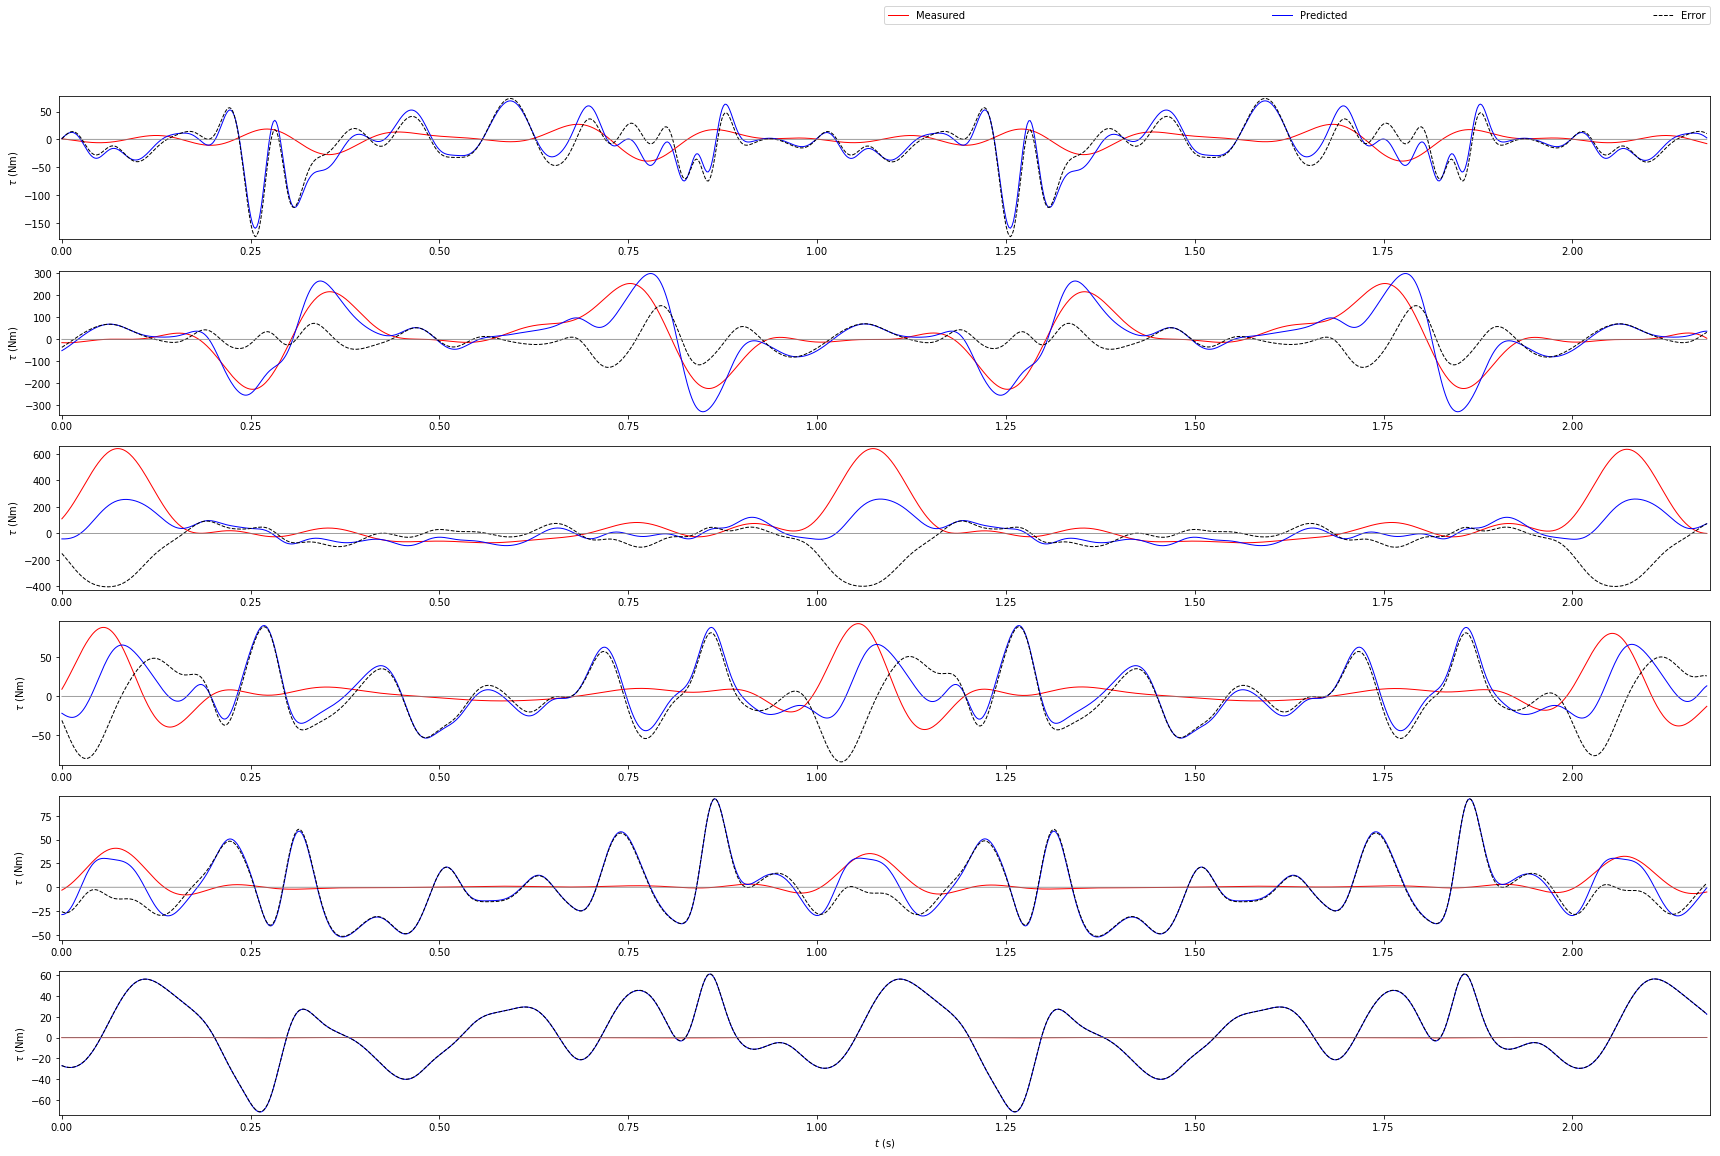

In [38]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_train[:plot_data_num, :], robot_def.coordinates_joint_type)

## Compare measured torque and predicted torque on the test set

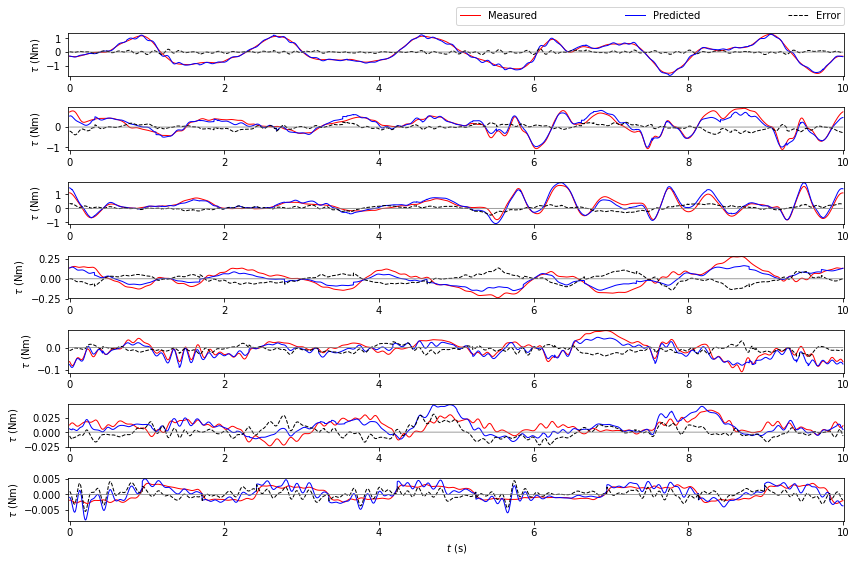

In [24]:
W_b_test, tau_s_test = gen_regressor(base_param_num, H_b_func, q_f_test,
                                       dq_f_test, ddq_f_test, tau_f_test)

tau_p_test = np.zeros(tau_f_test.shape)
tau_ps_test = W_b_test.dot(xb_ols)
for i in range(dof):
    tau_p_test[:, i] = tau_ps_test[i::dof]

plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_test[:plot_data_num, :], robot_def.coordinates_joint_type)

## Weighted Least Square (WLS)

### Training data set

In [22]:
# weight = np.sqrt(np.linalg.norm(tau_f - tau_p, axis=0)/(tau_f.shape[0] - base_param_num))
weight = np.max(tau_f_train, axis=0) - np.min(tau_f_train, axis=0)
weight
weight[1] /= 1
weight[2] /= 1
weight[3] /= 1
weight

array([6.62282136e+01, 4.81268176e+02, 7.11854590e+02, 1.35301612e+02,
       4.89236214e+01, 4.13767684e-01])

In [23]:
W_b_train.shape, tau_s_train.shape

In [24]:
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_train.shape[0]/weight.shape[0])

In [25]:
weights.shape

In [26]:
W_b_wls_train = np.multiply(W_b_train, np.asmatrix(weights).transpose())
tau_s_wls_train = np.multiply(tau_s_train, weights)

In [68]:
xb_wls = np.linalg.lstsq(W_b_wls_train, tau_s_wls_train)[0]

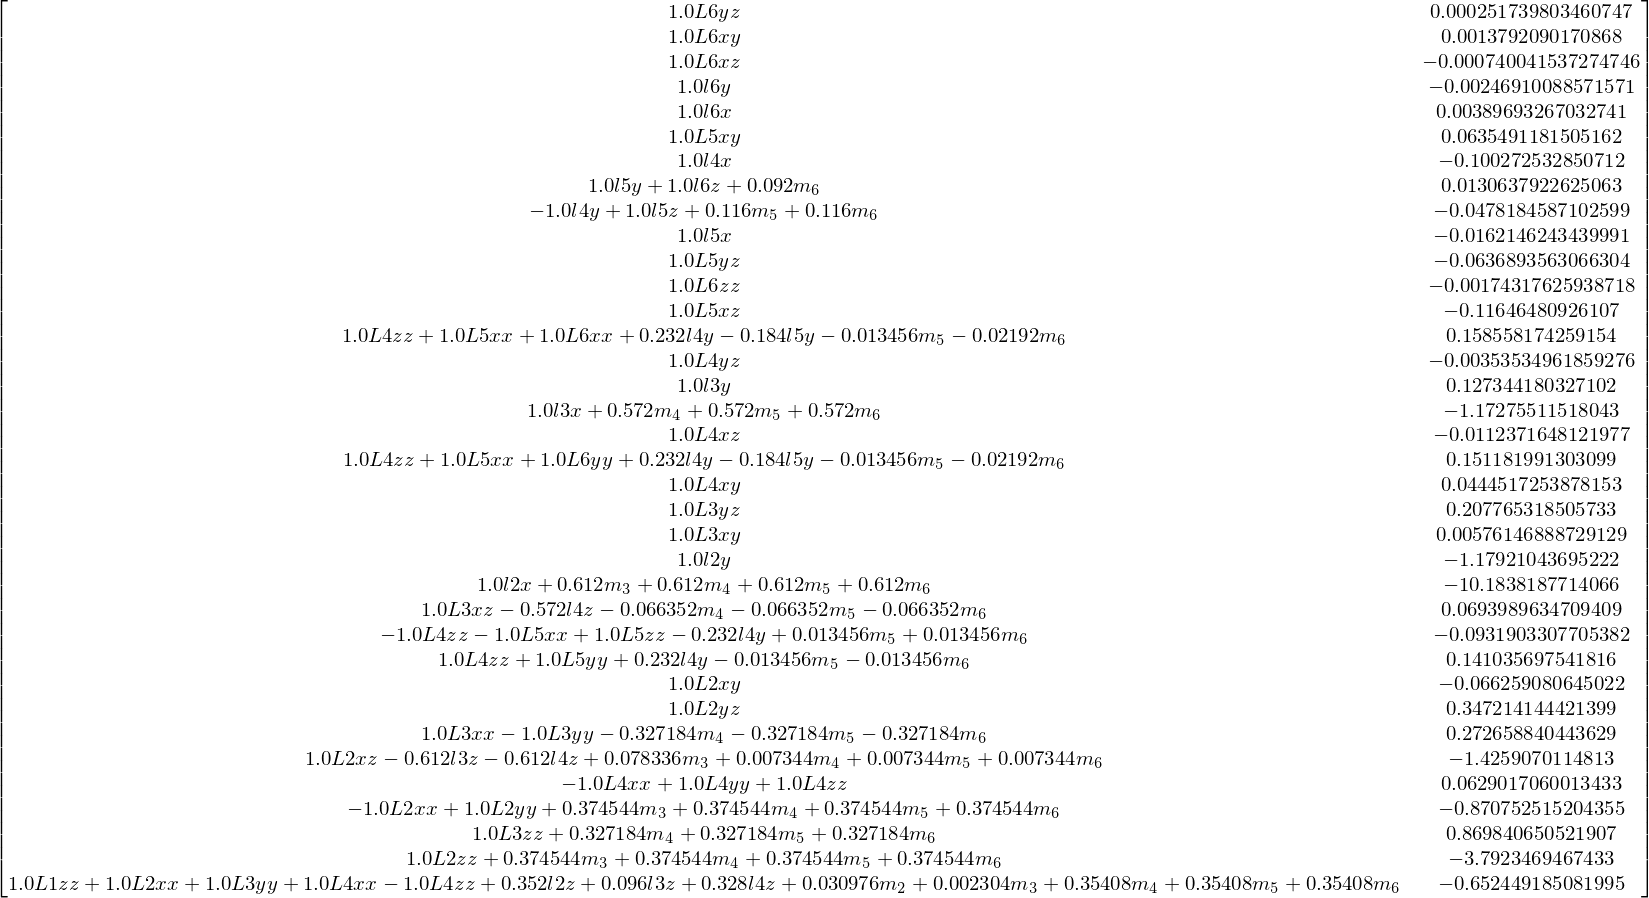

In [69]:
#np.set_printoptions(precision=2)
sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_wls))

In [70]:
tau_p_wls_train = np.zeros(tau_f_train.shape)
tau_ps_wls_train = W_b_train.dot(xb_wls)
for i in range(dof):
    tau_p_wls_train[:, i] = tau_ps_wls_train[i::dof]

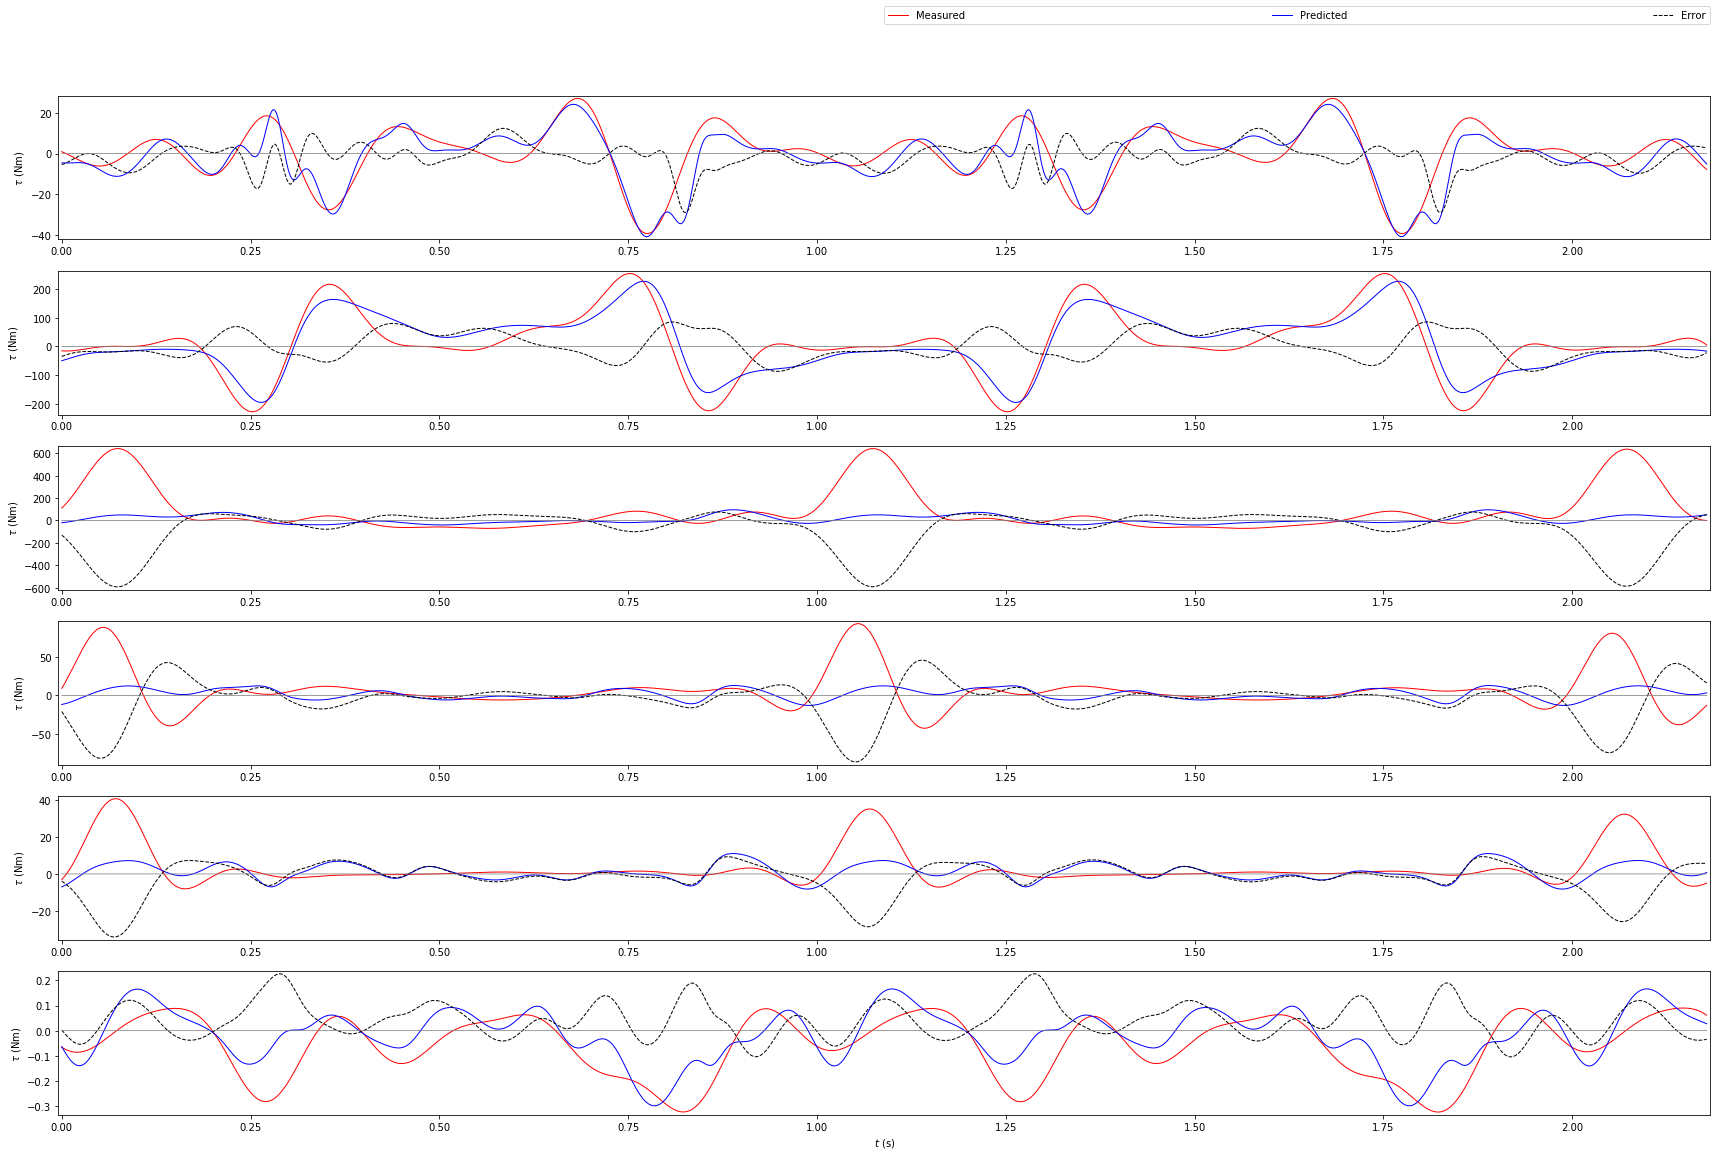

In [71]:
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_wls_train[:plot_data_num, :], robot_def.coordinates_joint_type)

In [72]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_wls_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([ 0.50030312,  0.41796182,  0.93366749,  0.96753737,  0.88035762,
        0.62313235])

In [73]:
robot_model.bary_param

In [74]:
robot_def.d_coordinates[0] != robot_def.dq_for_frame[1]

False

In [75]:
robot_model.coordinates[1].name[1:]

'2'

### Test data set

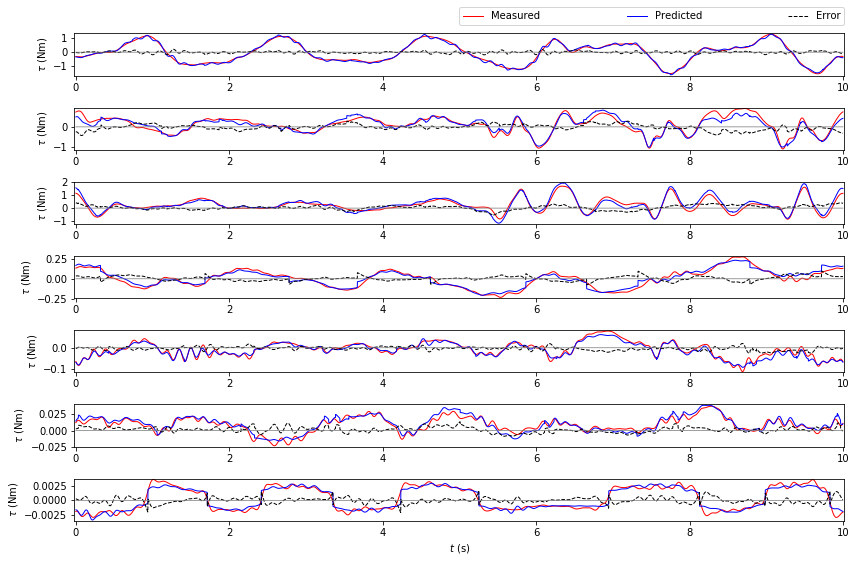

In [38]:
weight = np.max(tau_f_test, axis=0) - np.min(tau_f_test, axis=0)
weight
weight[1] /= 1
weight[2] /= 1
weight[3] /= 1
weight
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_test.shape[0]/weight.shape[0])

W_b_wls_test = np.multiply(W_b_test, np.asmatrix(weights).transpose())
tau_s_wls_test = np.multiply(tau_s_test, weights)

tau_p_wls_test = np.zeros(tau_f_test.shape)
tau_ps_wls_test = W_b_test.dot(xb_wls)
for i in range(dof):
    tau_p_wls_test[:, i] = tau_ps_wls_test[i::dof]

plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_wls_test[:plot_data_num, :], robot_def.coordinates_joint_type)

In [39]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_wls_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.09882667, 0.32787131, 0.31844911, 0.26594447, 0.25100447,
       0.29643101, 0.24416665])

## Convex optimization

### Generate regressor matrix for barycentric parameters

In [22]:
from identification.sdp_opt import SDPOpt

bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_train, tau_s_train = gen_regressor(bary_param_num, H_func,
                                     q_f_train, dq_f_train, ddq_f_train, tau_f_train)

ImportError: cannot import name sigtools

In [27]:
W_w_train = np.multiply(W_train, np.asmatrix(weights).transpose())
tau_w_s_train = np.multiply(tau_s_train, weights)

In [28]:
len(robot_model.std_param)

| min mass | max mass | min $r_x$ | max $r_x$ | min $r_y$ | max $r_y$ | min $r_z$ | max $r_z$ | max $F_c$ | max $F_v$ | max $F_o$ |
|----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|--------------|-----------|

In [29]:
sdp_constraints = []
spring_constraints = []
if model_name == 'mtm' or model_name == 'mtm_2spring_tendon':
    sdp_constraints = [(2, 20, -0.1, 0.1, -0.1, 0.1, -0.1, 0.3, 0.2, 0.2, 0.2),
                      (1, 10, -0.1, 0.2, -0.05, 0.05, -0.05, 0.05, 0.2, 0.2, 0.2),
                      (1, 10, -0.0, 0.3, -0.02, 0.02, -0.01, 0.01, 0.2, 0.2, 0.2),
                      (0.2, 5, -0.01, 0.01, -0.0, 0.1, -0.1, 0.0, 0.2, 0.2, 0.1),
                      (0.1, 2, -0.01, 0.01, -0.05, 0.0, -0.05, 0.0, 0.1, 0.1, 0.1),
                      (0.05, 0.5, -0.005, 0.005, -0.00, 0.05, -0.05, 0.0, 0.1, 0.1, 0.1),
                      (0.05, 0.5, -0.000, 0.000, -0.00, 0.00, -0.00, 0.05, 0.1, 0.1, 0.1),
                      (1, 10, -0.10, 0.05, -0.05, 0.05, -0.05, 0.05, 0.1, 0.2, 0.2),
                      (0.05, 0.5, 0.10, 0.15, -0.00, 0.00, 0.025, 0.03, 0.1, 0.1, 0.1),
                      (0.0, 0, 0.00, 0.00, -0.00, 0.00, 0.000, 0.00, 0.1, 0.1, 0.0)]
    spring_constraints = [(250, 300), (0.001, 0.1)]
elif model_name == 'mtm_3links':
    sdp_constraints = [(0.5, 10, -0.1, 0.1, -0.1, 0.1, -0.1, 0.3, 0.5, 0.5, 0.5),
                      (0.3, 5, -0.1, 0.2, -0.05, 0.05, -0.05, 0.05, 0.5, 0.5, 0.5),
                      (0.1, 3, -0.0, 0.3, -0.02, 0.02, -0.01, 0.01, 0.1, 0.5, 0.5),
                      (0.1, 1, -0.01, 0.01, -0.0, 0.1, -0.1, 0.0, 0.1, 0.1, 0.1),
                      (0.02, 0.3, -0.01, 0.01, -0.05, 0.0, -0.05, 0.0, 0.1, 0.1, 0.1),
                      (0.02, 0.2, -0.005, 0.005, -0.00, 0.05, -0.05, 0.0, 0.1, 0.1, 0.1),
                      (0.01, 0.1, -0.000, 0.000, -0.00, 0.00, -0.00, 0.05, 0.1, 0.1, 0.1),
                      (0.3, 5, -0.10, 0.05, -0.05, 0.05, -0.05, 0.05, 0.5, 0.5, 0.5),
                      (0.3, 5, 0.10, 0.15, -0.00, 0.00, 0.025, 0.03, 0.1, 0.1, 0.1),
                      (0.3, 5, 0.10, 0.15, -0.00, 0.00, 0.025, 0.03, 0.1, 0.1, 0.1)]
elif model_name == 'ur10':
    sdp_constraints = [(0.5, 10, -0.2, 0.2, -0.2, 0.2, -0.2, 0.2, 0.5, 0.5, 0.5),
                      (0.5, 10, -0.7, 0.7, -0.7, 0.7, -0.7, 0.7, 0.5, 0.5, 0.5),
                      (0.5, 10, -0.6, 0.6, -0.6, 0.6, -0.6, 0.6, 0.1, 0.5, 0.5),
                      (0.5, 10, -0.2, 0.2, -0.2, 0.2, -0.2, 0.2, 0.1, 0.1, 0.1),
                      (0.5, 10, -0.2, 0.2, -0.2, 0.2, -0.2, 0.2, 0.1, 0.1, 0.1),
                      (0.5, 10, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1, 0.1, 0.1, 0.1)]
else:
    raise Exception("No robot name matches " + model_name)

In [30]:


sdp_opt_std = SDPOpt(W_w_train, tau_w_s_train, robot_model,
                     sdp_constraints, spring_constraints)
# sdp_opt_std = SDPOpt(W, tau_s, robot_model, sdp_constraints)
%time sdp_opt_std.solve()

Regressor shape: (6540, 60)
Regressand shape: (6540,)
Creating variables...
Creating optimization objective...
Creating constraints...
Solving problem...
----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 205096, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 15000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 61, constraints m = 6717
Cones:	linear vars: 49
	soc vars: 6542, soc blks: 1
	sd vars: 126, sd blks: 6
Setup time: 1.45e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 7.49e+21  1.34e+21  1.00e+00 -2

  9300| 3.52e-03  1.78e-02  3.47e-05  4.36e+02  4.36e+02  9.24e-15  7.51e+01 
  9400| 1.80e-02  5.16e-02  2.19e-05  4.39e+02  4.39e+02  3.76e-14  7.59e+01 
  9500| 5.60e-03  1.03e-02  4.56e-06  4.36e+02  4.36e+02  4.21e-14  7.68e+01 
  9600| 4.00e-02  1.26e-01  1.83e-04  4.35e+02  4.35e+02  2.42e-13  7.74e+01 
  9700| 1.62e-02  2.54e-02  2.93e-05  4.35e+02  4.35e+02  1.31e-14  7.80e+01 
  9800| 5.07e-01  1.76e+00  2.87e-03  4.27e+02  4.29e+02  1.20e-12  7.86e+01 
  9900| 3.23e-03  7.53e-03  1.80e-05  4.36e+02  4.36e+02  8.84e-15  7.92e+01 
 10000| 7.51e-03  1.62e-02  2.79e-05  4.35e+02  4.35e+02  4.28e-14  7.98e+01 
 10100| 4.76e-02  9.56e-02  8.34e-05  4.36e+02  4.36e+02  1.67e-12  8.03e+01 
 10200| 1.72e-02  3.80e-02  3.74e-05  4.35e+02  4.35e+02  3.33e-14  8.09e+01 
 10300| 6.00e-02  3.16e-01  2.72e-04  4.38e+02  4.38e+02  1.29e-12  8.18e+01 
 10400| 1.82e-02  5.24e-02  2.23e-05  4.35e+02  4.35e+02  5.05e-13  8.36e+01 
 10500| 2.25e-02  5.78e-02  5.92e-05  4.36e+02  4.36e+02  3.07e-

## Compare measured torque and predicted torque on training set

### Generate predicted torque

In [31]:
tau_p_sdp_train = np.zeros(tau_f_train.shape)
tau_ps_sdp_train = W_train.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_train[:, i] = tau_ps_sdp_train[i::dof]

In [39]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_sdp_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([1.6218917 , 1.35539423, 0.99323848, 0.97332231, 0.95528067,
       0.62330669])

### Plot measured torque and predicted torque

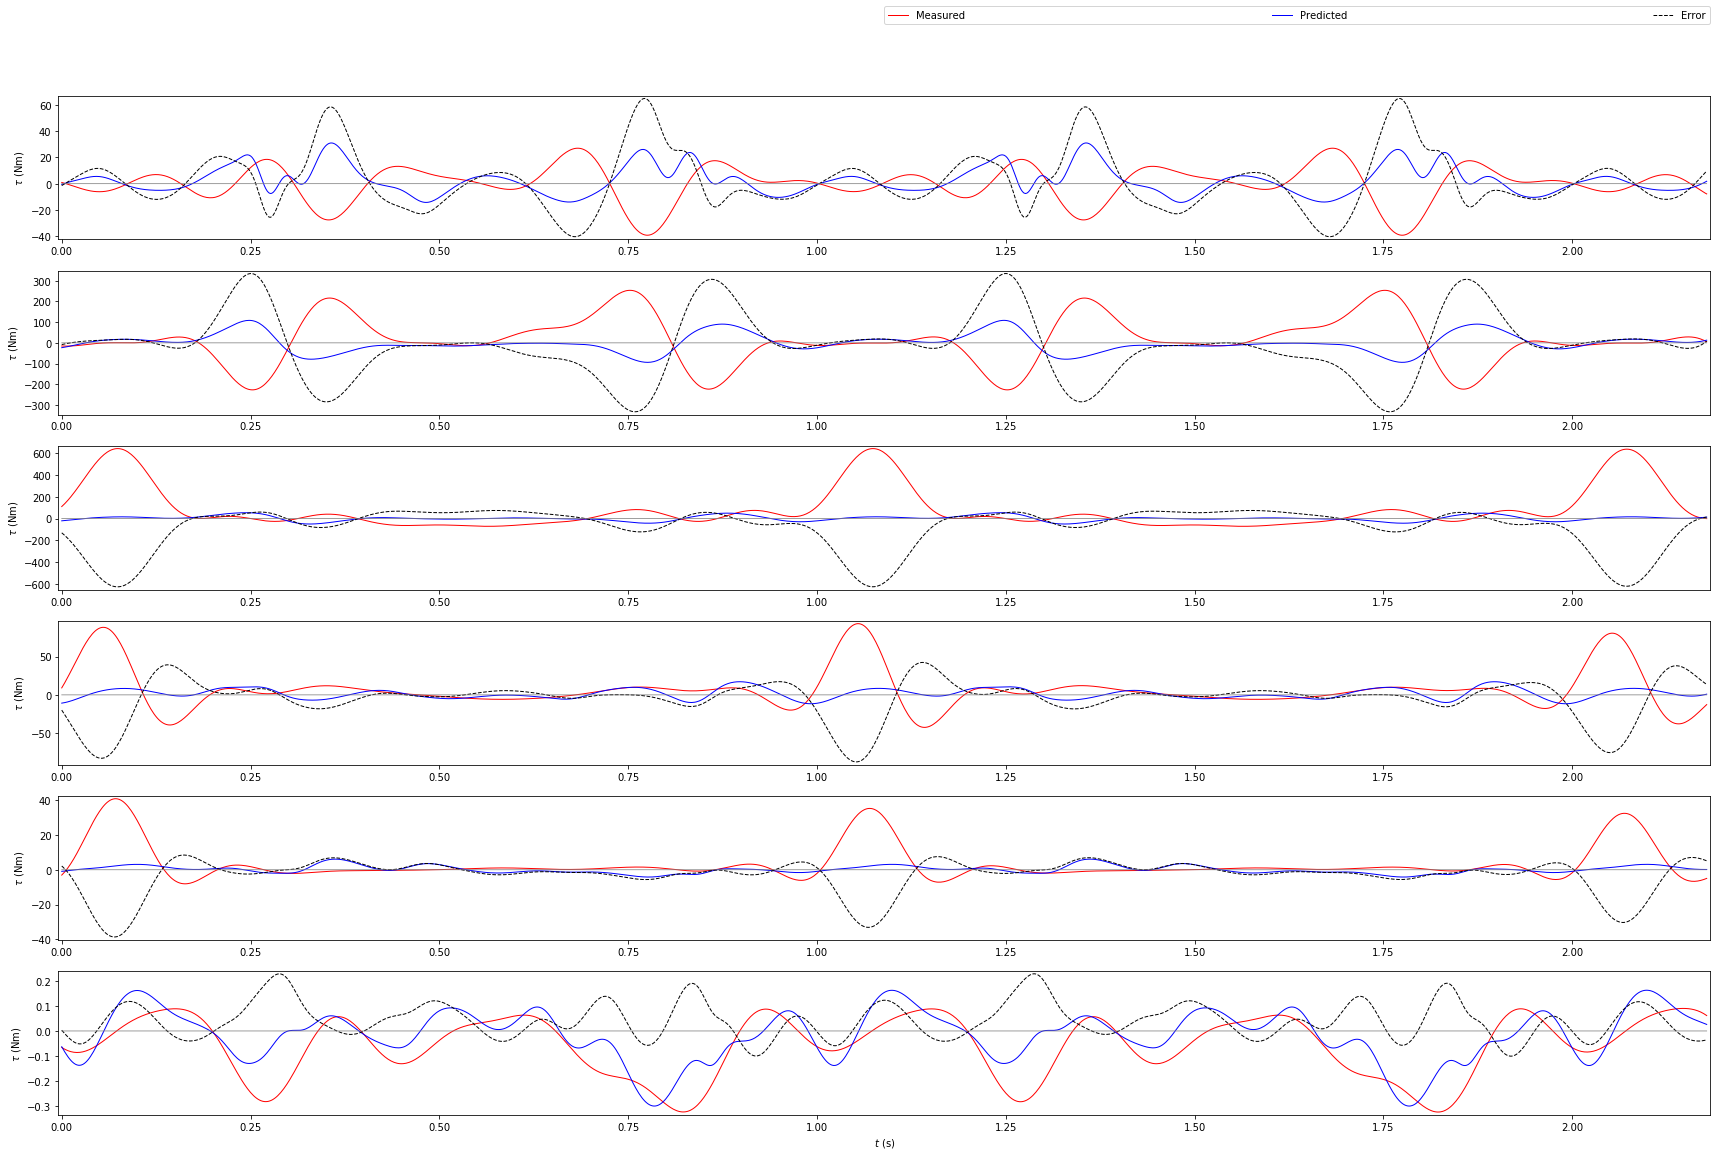

In [40]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num] - t_cut_train[0],
                   tau_f_train[:plot_data_num, :],
                   tau_p_sdp_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type)

## Compare measured torque and predicted torque on test set

In [48]:
bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_test, tau_s_test = gen_regressor(bary_param_num, H_func,
                                   q_f_test, dq_f_test, ddq_f_test, tau_f_test)

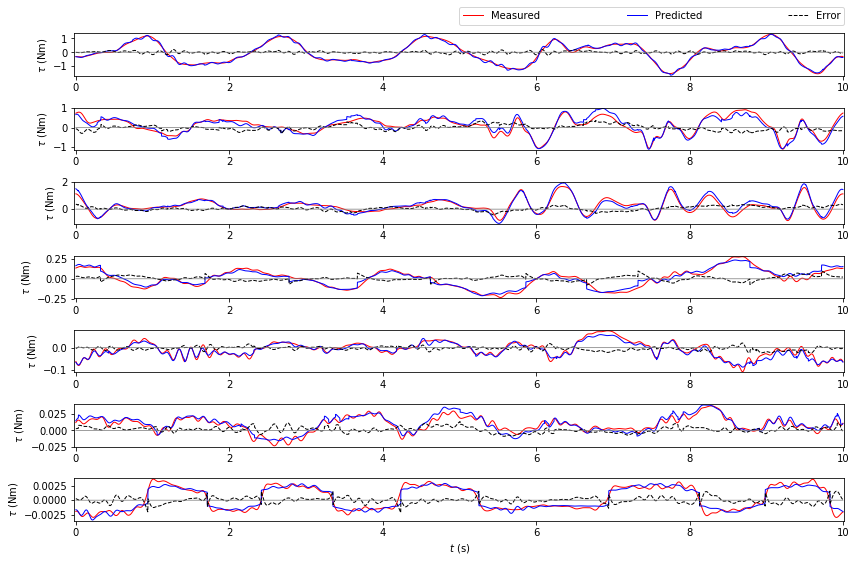

In [50]:
tau_p_sdp_test = np.zeros(tau_f_test.shape)
tau_ps_sdp_test = W_test.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_test[:, i] = tau_ps_sdp_test[i::dof]
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_test[:plot_data_num, :],
                   tau_p_sdp_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type)

In [51]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_sdp_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.09873854, 0.32554634, 0.28503159, 0.25680681, 0.25188883,
       0.29828242, 0.24384104])

In [52]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.bary_param), sympy.Matrix(sdp_opt_std.x_result))

⎡L1xx    2.62329073359542   ⎤
⎢                           ⎥
⎢L1xy  -4.44357673908701e-14⎥
⎢                           ⎥
⎢L1xz  1.24176529172002e-23 ⎥
⎢                           ⎥
⎢L1yy    2.62329073359544   ⎥
⎢                           ⎥
⎢L1yz  7.51924874279811e-17 ⎥
⎢                           ⎥
⎢L1zz   8.51282434659193e-6 ⎥
⎢                           ⎥
⎢l1x   5.11890740104509e-23 ⎥
⎢                           ⎥
⎢l1y   5.25518854421504e-19 ⎥
⎢                           ⎥
⎢l1z     0.514227823537837  ⎥
⎢                           ⎥
⎢ m₁     3.82336674535527   ⎥
⎢                           ⎥
⎢Fc₁    0.0283898258272331  ⎥
⎢                           ⎥
⎢Fv₁    0.0578097547985361  ⎥
⎢                           ⎥
⎢Fo₁    -0.0560868323074403 ⎥
⎢                           ⎥
⎢L2xx   0.0185462093391163  ⎥
⎢                           ⎥
⎢L2xy   0.00633823605412395 ⎥
⎢                           ⎥
⎢L2xz   0.00218205632030891 ⎥
⎢                           ⎥
⎢L2yy   0.0131146210401559  ⎥
⎢         

In [41]:
from identification import barycentric2standard_params

In [42]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_model)

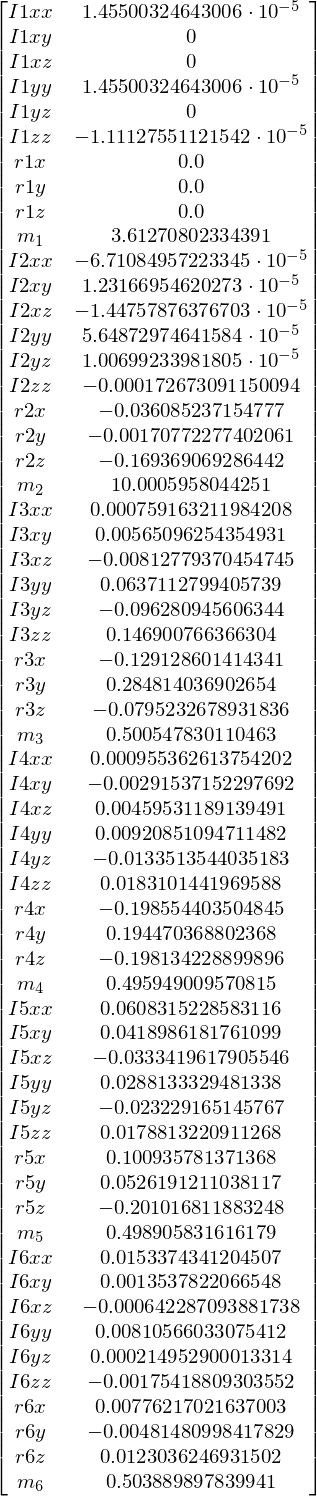

In [43]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.std_param), sympy.Matrix(x_std))

In [44]:
x_std